In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import random

In [2]:
basedir = r"Khadija/"

<b style = "font-size:2em"> Functions </b>

In [3]:
def getRandom (rang):
    """ Random index Generator Function

            params:
                rang (tuple) - range
    """

    r_min, r_max = rang
    result = random.randint(r_min, r_max)
#     print(result)
    return result

def doMonteCarlo (array, realizations):
    """Random value sampling 
         
         params:
             array (ndarray) - array of properties
             l (int)         - number of realizations
    """
    up = len(array)
    ls = []
    for i in range(realizations):
        index = getRandom ((0,up))
        ls.append(array[index - 1])
        
    return np.array(ls)

def getSTOIIP(GRV, NTG, poro, Sw, Bo):
    """Function to calculate STOIIP (Stock Tank Oil In Place) in STB
            params:
                GRV  (float64)- Gross Rock Volume in acre-ft
                NTG           - Net to Gross Ratio
                poro (ndarray)- 1D array of porosity realizations using MonteCarlo simulation
                Sw   (ndarray)- 1D array of Sw realizations using MonteCarlo simulation
                Bo   (float64)- Oil Formation Volume Factor (rb/stb)
    """
    STOIIP = GRV * NTG * poro * (1 - Sw) / Bo
    
    return 7758 * STOIIP

## Load Data and Pre-Process

In [4]:
well1 = pd.read_csv(basedir + "well1.csv")
well2 = pd.read_csv(basedir + "well2.csv")
well3 = pd.read_csv(basedir + "well3.csv")
well4 = pd.read_csv(basedir + "well4.csv")
well5 = pd.read_csv(basedir + "well5.csv")
well6 = pd.read_csv(basedir + "well6.csv")

In [5]:
well1 = well1[well1['Porosity'].notnull()]
well2 = well2[well2['Porosity'].notnull()]
well3 = well3[well3['Porosity'].notnull()]
well4 = well4[well4['Porosity'].notnull()]
well5 = well5[well5['Porosity'].notnull()]
well6 = well6[well6['Porosity'].notnull()]

In [6]:
porosity_south = np.concatenate([well1['Porosity'], well2['Porosity'], well3['Porosity'], 
                           well4['Porosity']])
Sw_south       = np.concatenate([well1['Saturation '], well2['Saturation '], well3['Saturation '], 
                           well4['Saturation ']])

porosity_north = np.concatenate([well5['Porosity'], well6['Porosity']])
                          
Sw_north      = np.concatenate([well5['Saturation '], well6['Saturation ']])


In [7]:
well1['Porosity']

0      0.187236
1      0.212030
2      0.220514
3      0.268247
4      0.277016
         ...   
805    0.247879
806    0.239394
807    0.232121
808    0.229305
809    0.228515
Name: Porosity, Length: 808, dtype: float64

In [8]:
max(porosity_south)

0.356692

Text(0.5, 1.0, 'North Block Sw Distribution')

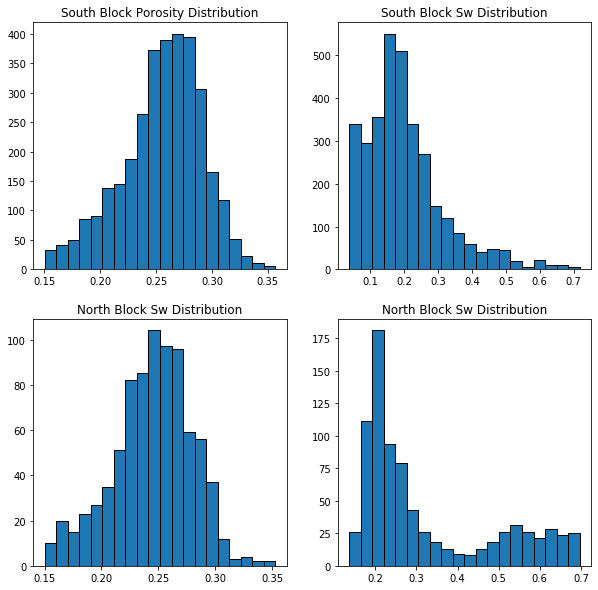

In [9]:
fig = plt.figure (figsize=(10,10))

ax1 = fig.add_subplot(221)
ax1.hist(porosity_south, edgecolor = 'black', bins = 20)
ax1.set_title("South Block Porosity Distribution")

ax2 = fig.add_subplot(222)
ax2.hist(Sw_south, edgecolor = 'black', bins = 20)
ax2.set_title("South Block Sw Distribution")

ax3 = fig.add_subplot(223)
ax3.hist(porosity_north, edgecolor = 'black', bins = 20)
ax3.set_title("North Block Sw Distribution")

ax4 = fig.add_subplot(224)
ax4.hist(Sw_north, edgecolor = 'black', bins = 20)
ax4.set_title("North Block Sw Distribution")

## Monte-Carlo Simulation

### 2 - Defining STOIIP Input Parameters

In [10]:
NTG_South = 0.75
NTG_North = 0.38

Bo = 1.323

GRV_South = 0.0008472357230624649 * 10**9
GRV_North  = 0.00019273594871023391121  * 10**9

### 3 - Calculation and Visualization of STOIIP

In [11]:
from matplotlib.ticker import FormatStrFormatter
from scipy.stats import norm

In [28]:
def visualize (STOIIP):
    fig = plt.figure(figsize=(10, 4))
    
    
    
    ax1 = fig.add_subplot(1,2,1)
    ax1.hist(STOIIP, edgecolor = 'black', bins = 20, color = "#4f4e4c")
    ax1.set_title ("STOIIP (PDF)")
    ax1.grid(True)
    xlabels = ['{:,.0f}'.format(x) + 'M' for x in ax1.get_xticks()/1000000]
#     ax1.set_xticklabels(xlabels.astype(int))
    ax1.set_xticklabels(xlabels)
    
    
    ax2 = fig.add_subplot(1,2,2)
    counts, bins, bars = ax2.hist(STOIIP, edgecolor = 'black', color = '#ff6608', bins = 20, cumulative=True, density = True)
    ax2.grid(True)
    ax2.invert_xaxis()
    xlabels2 = ['{:,.0f}'.format(x) + 'M' for x in ax2.get_xticks()/1000000]
    ax2.set_xticklabels(xlabels2)
    
    bins = np.delete(bins, -1)
    ax2.plot(bins, (1 - counts), ls = '--', lw = '2.5', c = '#2d08ff')
    ax2.set_title ("STOIIP (CDF)")


South Block STOIIP


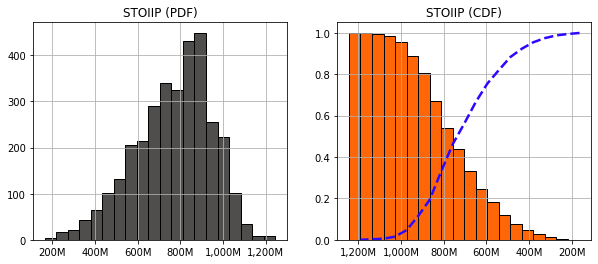

In [29]:
STOIIP_South = getSTOIIP(GRV_South, NTG_South, porosity_south, Sw_south, Bo)
visualize(STOIIP_South)
print('South Block STOIIP')

In [15]:
mu_South, sigma_South = norm.fit(STOIIP_South)

In [16]:
print("South Block STOIIP stats")
print("------------------------")
print("P90:{} MMSTB".format(norm.ppf(0.10, loc = mu_South, scale = sigma_South)/10**6))
print("P50:{} MMSTB".format(norm.ppf(0.50, loc = mu_South, scale = sigma_South)/10**6))
print("P10:{} MMSTB".format(norm.ppf(0.90, loc = mu_South, scale = sigma_South)/10**6))

South Block STOIIP stats
------------------------
P90:537.9189579311774 MMSTB
P50:767.5273777021231 MMSTB
P10:997.1357974730687 MMSTB


North Block STOIIP


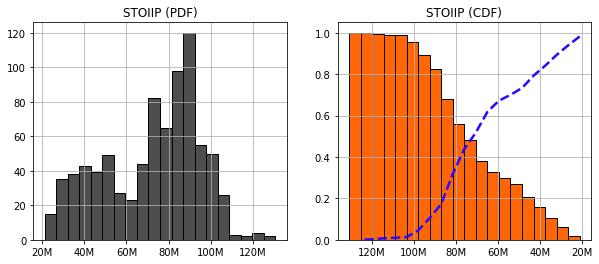

In [30]:
STOIIP_North = getSTOIIP(GRV_North, NTG_North, porosity_north, Sw_north, Bo)
visualize(STOIIP_North)
print("North Block STOIIP")

In [18]:
mu_North, sigma_North = norm.fit(STOIIP_North)

In [19]:
print("North Block STOIIP stats")
print("------------------------")
print("P90:{} MMSTB".format(norm.ppf(0.10, loc = mu_North, scale = sigma_North)/10**6))
print("P50:{} MMSTB".format(norm.ppf(0.50, loc = mu_North, scale = sigma_North)/10**6))
print("P10:{} MMSTB".format(norm.ppf(0.90, loc = mu_North, scale = sigma_North)/10**6))

North Block STOIIP stats
------------------------
P90:42.77968373618102 MMSTB
P50:72.17720096991536 MMSTB
P10:101.5747182036497 MMSTB
